In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
monthly_bins = list(range(0, 30*11, 30))  # For charting, 30-days per group.
monthly_bins.append(9999)
grade_bins = [0, 69, 79, 89, 100]
grade_bin_labels = ['SCORE', 'C', 'B', 'A']  # Lowest grade (<70) is not a letter grade, but "SCORE".
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figsize = (15, 8)
data_path = join('..', 'data')  # The data directory is up one level, i.e., "../data".
# URL for latest inpsection data.
# http://ehservices.publichealth.lacounty.gov/LIVES/LABusinesses.zip
#
# Create and load Businesses dataframe.
with open('{}.csv'.format(join(data_path, 'businesses')), encoding='utf-8', errors='ignore') as f:
    bdf_raw = pd.read_csv(f, index_col=False)
bdf = bdf_raw.drop_duplicates(['business_id'], keep='last').copy()
bdf.sort_values(by=['business_id'], inplace=True)
#
# Create and load Local Inspections dataframe.
with open('{}.csv'.format(join(data_path, 'inspections')), encoding='utf-8', errors='ignore') as f:
    idf_raw = pd.read_csv(f, index_col=False)
idf = idf_raw.drop_duplicates(['business_id', 'date'], keep='last').copy()
idf['visit'] = pd.to_datetime(idf['date'].apply(str), format='%Y%m%d')
# Ignore any inspection records with an invalid business_id.
idf = pd.merge(idf, bdf[['business_id']], on='business_id')
idf.sort_values(by=['business_id','visit'], inplace=True)
#
# Create and load Violations dataframe.
with open('{}.csv'.format(join(data_path, 'violations')), encoding='utf-8', errors='ignore') as f:
    vdf_raw = pd.read_csv(f, index_col=False)
vdf = vdf_raw.drop_duplicates().copy()
vdf['visit'] = pd.to_datetime(vdf['date'].apply(str), format='%Y%m%d')
# Ignore any violation records with an invalid business_id + visit.
vdf = pd.merge(vdf, idf.loc[:, ['business_id', 'visit']], on=['business_id', 'visit'])
vdf.sort_values(by=['business_id','visit', 'code'], inplace=True)

In [2]:
earliest_inspection_date = idf['visit'].min()
latest_inspection_date = idf['visit'].max()
one_year_prior_date = latest_inspection_date - pd.Timedelta(days=364)
# Create column dayovweek for dayofweeek that the inspection occurred.
idf['dayofweek'] = idf['visit'].dt.dayofweek
# Create the column interval and assign to it the number of days until the next inspection occurs.
idf['interval'] = -(idf.groupby('business_id')['visit'].diff(periods=-1)) / np.timedelta64(1, 'D')
# Create the column grade and assign to it the letter grade for the inspection score.
idf['grade'] = pd.cut(idf['score'], bins=grade_bins, include_lowest=True, labels=grade_bin_labels)
# Create the column avg_score and assign to it the mean (average) score of all inspections for that business id.
idf['avg_score'] = idf.groupby('business_id')['score'].transform("mean")
# Create the column min_score and assign to it the minimum score of all inspections for that business id.
idf['min_score'] = idf.groupby('business_id')['score'].transform("min")
# Create the column max_score and assign to it the maximum score of all inspections for that business id.
idf['max_score'] = idf.groupby('business_id')['score'].transform("max")
# Create the column median_score and assign to it the median (middle) score of all inspections for that business id.
idf['median_score'] = idf.groupby('business_id')['score'].transform("median")

In [3]:
# Create a dataframe that excludes the last inspection per-business (i.e., number of days til next inpection is known.)
tdf = idf.dropna(subset=['interval']).copy()
# Categorize into monthly bins.
tdf['bin'] = pd.cut(tdf['interval'], bins=monthly_bins, right=False)
# Create a dataframe holding the count of businesses for each bin.
dbdf = tdf.groupby('bin').size().to_frame('count')

In [4]:
# Create a dataframe that has only the last inspection per-buiness.
cdf = idf[idf['interval'].isnull()].copy()
# Update the interval column with the number of days that have passed with no further inspection.
cdf['interval'] =(pd.to_datetime('today') - cdf['visit']) / np.timedelta64(1, 'D')
# Categorize into monthly bins.
cdf['bin'] = pd.cut(cdf['interval'], bins=monthly_bins, right=False)
# Create a dataframe holding the count of businesses for each bin.
lidf = cdf.groupby('bin').size().to_frame('count')

In [5]:
# Create a dataframe for summarized number of inspections per dayofweek.
wdf = idf.groupby('dayofweek').size().to_frame('num_visits')
wdf['pct'] = (wdf['num_visits'] / wdf['num_visits'].sum()) * 100

In [6]:
# Create a dataframe for summarized inspection grades per weekday.
gdf = idf.groupby(['dayofweek', 'grade']).size().to_frame('count').reset_index().pivot(index='grade', columns='dayofweek', values='count')
# Convert values to percentages.
gdf = (gdf / gdf.sum()) * 100

In [7]:
# Create a dataframe with the number of inspections in the past year for each business.
bidf = idf[idf['visit'] >= one_year_prior_date].groupby('business_id').size().to_frame('num_visits')
# Create a dataframe for count of businesses for each level of N inspections for the year.
sdf = bidf.groupby('num_visits').size().to_frame('num_businesses')
# Create a column that shows the number of businesses with N inspections per year, as a percent of all businesses.
sdf['pct'] = (sdf['num_businesses'] / sdf['num_businesses'].sum()) * 100

In [8]:
# Create a dataframe with a count of each violation.
vcdf = vdf.groupby(['code', 'description']).size().to_frame('count').sort_values(by='count', ascending=False)
# Create a column that shows the percentage of all violations that this violation represents.
vcdf['pct'] = (vcdf['count'] / vcdf['count'].sum()) * 100

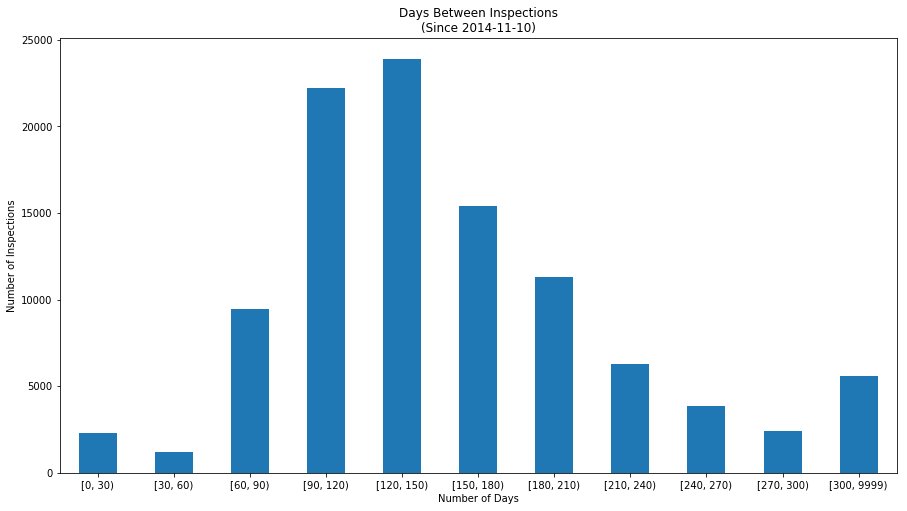

In [9]:
# Plot the Days Between Inspections chart using number of businesses per bin.
sns.reset_orig()
ax = dbdf.plot(kind='bar', figsize=figsize, legend=False, title='Days Between Inspections\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of Inspections')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
pass

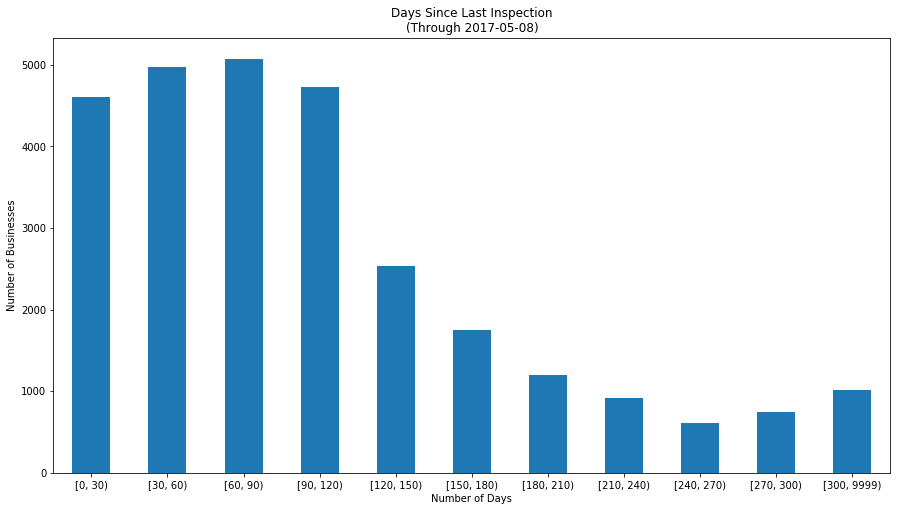

In [10]:
# Plot the Days Since Last Inspection chart using number of businesses per bin.
sns.reset_orig()
ax = lidf.plot(kind='bar', figsize=figsize, legend=False, title='Days Since Last Inspection\n(Through {:%Y-%m-%d})'.format(latest_inspection_date))
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of Businesses')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
pass

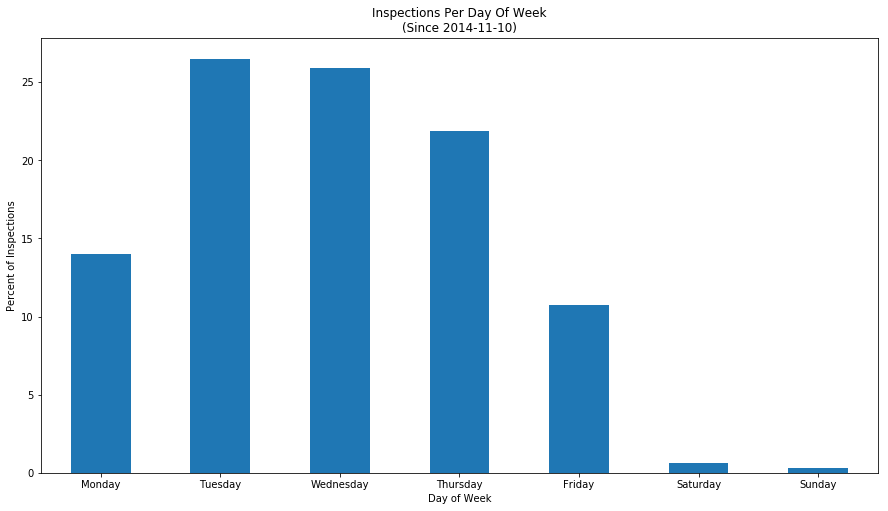

In [11]:
# Plot the Inspections Per Day Of Week chart as percentages.
sns.reset_orig()
ax = wdf['pct'].plot(kind='bar', figsize=figsize, title='Inspections Per Day Of Week\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xticklabels(weekday_names)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percent of Inspections')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
pass

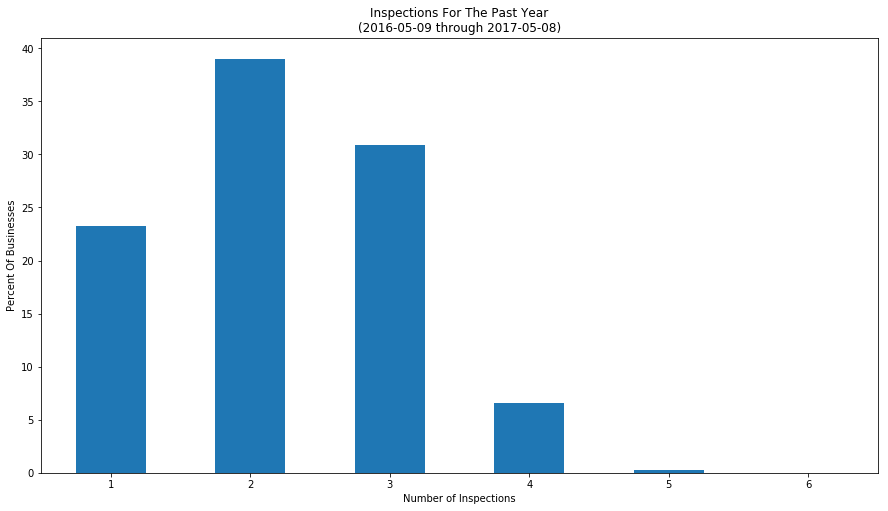

In [12]:
# Plot the Inspections For The Past Year chart.
sns.reset_orig()
ax = sdf['pct'].plot(kind='bar', figsize=figsize, title='Inspections For The Past Year\n({:%Y-%m-%d} through {:%Y-%m-%d})'.format(one_year_prior_date, latest_inspection_date))
ax.set_xlabel('Number of Inspections')
ax.set_ylabel('Percent Of Businesses')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
pass

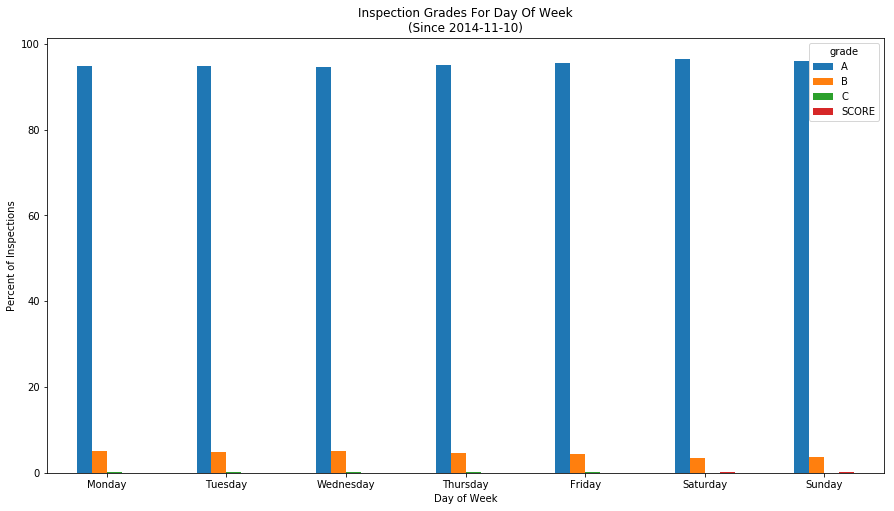

In [13]:
# Plot the Inspection Grades For Day Of Week chart.
sns.reset_orig()
ax = gdf.T.plot(kind='bar', figsize=figsize, title='Inspection Grades For Day Of Week\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xticklabels(weekday_names)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percent of Inspections')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
pass

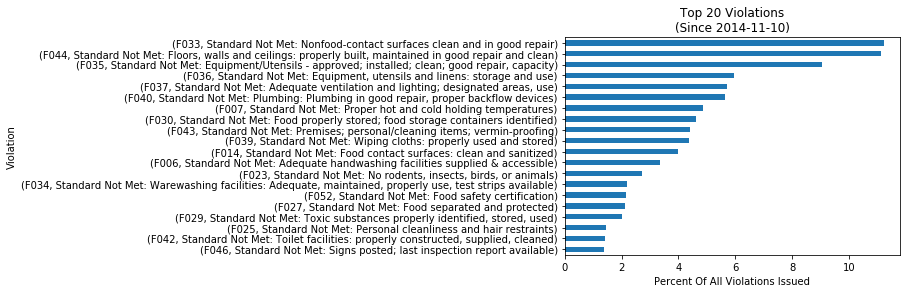

In [14]:
# Plot the Top 20 Violations chart.
sns.reset_orig()
ax = vcdf['pct'].head(20).iloc[::-1].plot(kind='barh', title='Top 20 Violations\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xlabel('Percent Of All Violations Issued')
ax.set_ylabel('Violation')
pass

In [15]:
bndf = pd.merge(bdf[['business_id', 'name']], cdf[['business_id', 'interval', 'score', 'grade']], on='business_id')
sbxdf = bndf[bndf['name'].str.contains("STARBUCK")]
sbxdf1y = sbxdf[sbxdf['interval'] > 365]
sbxmindf = sbxdf[sbxdf['score'] == sbxdf['score'].min()]
print ('Number of Starbucks locations that have not been inspected in the past year: {:d}.'.format(sbxdf1y['business_id'].count()))
print ('Median number of days since last inspection for this group: {:d} days.'.format(int(sbxdf1y['interval'].median())))
print ('Lowest grade (score) of all {:d} STARBUCKS locations: {} ({:d})'.format(len(sbxdf.index), sbxmindf['grade'].head(1).values[0], int(sbxmindf['score'].head(1).values[0])))

Number of Starbucks locations that have not been inspected in the past year: 48.
Median number of days since last inspection for this group: 478 days.
Lowest grade (score) of all 582 STARBUCKS locations: A (90)


In [16]:
# List businesses that are outliers in that they had less than a certain score and would normally be inspected soon, but the inspection has not happened yet.
#
# Some business types are low risk and inspected less frequently (e.g., annually).  But the LABusinesses.zip does not include that "risk" category.  So deduce it from historic inspection frequence.  E.g., 3 inspections/year or more would mean likely "high or moderate risk".
normal_inspections_per_year_min = 3
# The days_since_last_inspection_min setting can be adjusted to cast a wider net. E.g., Even though a business might average 3 inspections per year (every 120 days), they would be due for another soon after just 90 days.
days_since_last_inspection_min = 120
# The last_inspection_score_max setting can be adjusted to exclude businesses that had a better score in the last inspection.  A business that had an A (>=90) might not be priority for another visit soon even though it has been a while, whereas another business with same amount of tim esince last inspection might be due to having received a poorer score.
last_inspection_score_max = 89
# How many rows (max) to display?
display_rows = 50
# Create a dataframe of businesses with a column for the average number of days between inspections by looking at only prior inspections (excluding the most recent).
iatdf = (tdf.groupby('business_id')['interval'].sum() / tdf.groupby('business_id')['interval'].count()).to_frame('interval_avg')
# Create a dataframe of just the latest inspection that also has this column with the businesses average days between inspections.
miadf = pd.merge(cdf, iatdf, left_on='business_id', right_index=True)
# Create a dataframe of just the businesses who essentially are due for an inspection and the latest inspection was below a certain score.
latedf = miadf[(miadf['interval_avg'] <= (365 / normal_inspections_per_year_min)) & (miadf['interval'] > days_since_last_inspection_min) & (miadf['score'] <= last_inspection_score_max)]
# Show the list of these businesses and last inspection/visit, likely to get an inspection soon.
pd.merge(bdf[['business_id', 'name', 'address', 'city']], latedf, left_on='business_id', right_on='business_id').sort_values('interval', ascending=False)[['business_id', 'name', 'city', 'visit', 'grade']].head(display_rows)

,business_id,name,city,visit,grade
24,PR0157234,SEAFOOD PALACE,MONTEREY PARK,2015-09-16,B
17,PR0129695,CAFE CON LECHE,LOS ANGELES,2015-10-21,B
28,PR0168948,THE BIG CATCH,LOS ANGELES,2016-04-26,B
26,PR0164475,POBLANOS BAKERY,WEST COVINA,2016-04-26,B
1,PR0003267,MARCO'S TRATTORIA PIZZERIA I,WEST HOLLYWOOD,2016-07-12,B
25,PR0160808,CITTA,SIERRA MADRE,2016-07-20,B
20,PR0148745,SALAD FARM,ALHAMBRA,2016-07-28,B
21,PR0151304,GALLERIA FOODS CHINA CUISINE,ROWLAND HEIGHTS,2016-08-03,B
29,PR0168975,TASTY DUMPLING HOUSE,ALHAMBRA,2016-09-16,B
27,PR0168629,TARA'S HIMALAYAN CUISINE,LOS ANGELES,2016-09-20,B


In [17]:
def init_busgrp(bgs, bus_grp_name, category):
    bgdf = pd.DataFrame(bdf[bgs]['business_id'])
    bgdf['name'] = bus_grp_name
    bgdf['category'] = category
    return bgdf
chdf = pd.DataFrame(data=None, columns=bdf[['business_id', 'name']].columns)
chdf['category'] = None
chdf = chdf.append(init_busgrp((bdf['name'] == "NORM'S") | ((bdf['name'].str.contains("NORM'S")) & (bdf['name'].str.contains("REST"))), 'NORMS', 'CASUAL DINING'))
def init_busgrp(bgs, bus_grp_name, category):
    bgdf = pd.DataFrame(bdf[bgs]['business_id'])
    bgdf['name'] = bus_grp_name
    bgdf['category'] = category
    return bgdf
chdf = pd.DataFrame(data=None, columns=bdf[['business_id', 'name']].columns)
chdf['category'] = None
chdf = chdf.append(init_busgrp((bdf['name'] == "NORM'S") | ((bdf['name'].str.contains("NORM'S")) & (bdf['name'].str.contains("REST"))), 'NORMS', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BAJA FRESH'), 'BAJA FRESH', 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BASKIN') & bdf['name'].str.contains('ROB'), 'BASKIN ROBBINS', 'ICE CREAM PARLOR'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BLAZE') & bdf['name'].str.contains('PIZZA'), 'BLAZE PIZZA', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BOBA') & bdf['name'].str.contains('LOCA'), 'BOBA LOCA', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BUFFALO') & bdf['name'].str.contains('WILD'), 'BUFFALO WILD WINGS', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('BURGER KING'), 'BURGER KING', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('CARL') & bdf['name'].str.contains('JR'), "CARL'S JR.", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("CHEESE") & bdf['name'].str.contains("CAKE") & bdf['name'].str.contains("FACTORY"), 'THE CHEESECAKE FACTORY', 'FINE DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('CHILE') & bdf['name'].str.contains('VERDE'), 'CHILE VERDE', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('CHINA EXPRESS'), 'CHINA EXPRESS', 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('CHIPOTLE'), 'CHIPOTLE MEXICAN GRILL', 'FAST FOOD'))
chdf = chdf.append(init_busgrp((bdf['name'].str.contains('COFEE') | bdf['name'].str.contains('COFFEE')) & bdf['name'].str.contains('BEAN'), 'THE COFFEE BEAN & TEA LEAF', 'COFFEEHOUSE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('COLD STONE') | bdf['name'].str.contains('COLDSTONE'), 'COLD STONE CREAMERY', 'ICE CREAM PARLOR'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('DAILY DONUT'), 'DAILY DONUTS', 'DONUT'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('DEL TACO'), 'DEL TACO', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith("DENNY'S") | bdf['name'].str.startswith("DENNYS"), "DENNY'S", 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('DOMINO'), "DOMINO'S PIZZA", 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('DONUT') & bdf['name'].str.contains('KING'), 'DONUT KING', 'DONUT'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('EDIBLE') & bdf['name'].str.contains('ARRANGEMENT'), 'EDIBLE ARRANGEMENTS', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('FAT') & bdf['name'].str.contains('BURGER'), 'FATBURGER', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('FLAME') & bdf['name'].str.contains('ROILER'), 'THE FLAME BROILER', 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('HONG') & bdf['name'].str.contains('KONG') & bdf['name'].str.contains('EXPRESS'), "HONG KONG EXPRESS", 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('HOT DOG') & bdf['name'].str.contains('STICK'), "HOT DOG ON A STICK", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('IHOP') | bdf['name'].str.contains('I HOP') | bdf['name'].str.contains('I-HOP'), 'IHOP', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('JACK') & bdf['name'].str.contains('BOX'), 'JACK IN THE BOX', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('JAMBA JUICE'), 'JAMBA JUICE', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('JERSEY MIKE'), "JERSEY MIKE'S SUBS", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("JIMMY") & (bdf['name'].str.contains("JOHN") | bdf['name'].str.contains("JON")), "JIMMY JOHN'S", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('JOHNNY ROCKET'), 'JOHNNY ROCKETS', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('KFC') | (bdf['name'].str.contains('KENTUCK') & bdf['name'].str.contains('CH')), 'KENTUCKY FRIED CHICKEN', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("LEE'S") & bdf['name'].str.contains('SANDWICHES'), "LEE'S SANDWICHES", 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('LITTLE CAESAR') | bdf['name'].str.contains('LITTLE CEASAR') | bdf['name'].str.contains('CEASAR PIZZA'), 'LITTLE CAESARS', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('LOUISIANA') & (bdf['name'].str.contains('CHIC') | bdf['name'].str.contains('CHK')), 'LOUSIANA FAMOUS FRIED CHICKEN', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('MC') & (bdf['name'].str.contains('DONALD') | bdf['name'].str.contains('DOMALD')), "MCDONALD'S", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('ONO') & (bdf['name'].str.contains('BBQ') | bdf['name'].str.contains('HAWAIIAN')), 'ONO HAWAIIAN BBQ', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PANDA') & bdf['name'].str.contains('EXPRESS'), 'PANDA EXPRESS', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PANERA'), 'PANERA BREAD', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PAPA JOHN'), "PAPA JOHN'S PIZZA", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("PIEOLOGY"), 'PIEOLOGY', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PINK') & bdf['name'].str.contains('BERRY'), 'PINKBERRY', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PIZZA') & bdf['name'].str.contains('HUT'), 'PIZZA HUT', 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('POLLO') & bdf['name'].str.contains('LOC'), "EL POLLO LOCO", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('PRESSED') & bdf['name'].str.contains('JUIC') & ~bdf['name'].str.contains('BROTHER') & ~bdf['name'].str.contains('PURE'), 'PRESSED JUICERY', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('QUOTIDIEN'), 'LE PAIN QUOTIDIEN', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('ROUND') & bdf['name'].str.contains('PIZZA'), 'ROUND TABLE PIZZA', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp((bdf['name'].str.contains('RUBIO') & bdf['name'].str.contains('GRILL')) | (bdf['name'] == "RUBIO'S") | ((bdf['name'] == "RUBIO'S RESTAURANT")), "RUBIO'S", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('SOUPLANTATION'), 'SOUPLANTATION', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('STAR') & bdf['name'].str.contains('BUCK'), 'STARBUCKS', 'COFFEEHOUSE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('SUBWAY'), 'SUBWAY', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('TACO') & bdf['name'].str.contains('BELL'), 'TACO BELL', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('THE HABIT') | bdf['name'].str.contains('HABIT BURGER GRILL'), 'THE HABIT BURGER GRILL', 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('TOGOS') | bdf['name'].str.contains('TOGO EATERY') | bdf['name'].str.contains('TOGO\'S'), "TOGO'S", 'FAST CASUAL'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('TRIMANA') & ~(bdf['name'] == 'TRIMANA EXPRESS'), 'TRIMANA', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('TUTTI') & bdf['name'].str.contains('FRUTTI'), 'TUTTI FRUTTI FROZEN YOGURT', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('WABA'), "WABA GRILL", 'FAST CASUAL'))
chdf = chdf.append(init_busgrp((bdf['name'].str.contains('WEINER') | bdf['name'].str.contains('WIENER')) & bdf['name'].str.contains('NITZEL'), 'WIENERSCHNITZEL', 'FAST FOOD'))
chdf = chdf.append(init_busgrp((bdf['name'] == "WENDY'S") | (bdf['name'] == "WENDY'S OLD-FASHIONED HAMBUR") | (bdf['name'] == "WENDY'S RESTAURANT") | (bdf['name'].str.contains("WENDY\'*S* *#* *\d+")), "WENDY'S", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('WETZEL') | bdf['name'].str.contains('WEZEL'), "WETZEL'S PRETZELS", 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('WING') & bdf['name'].str.contains('STOP'), 'WINGSTOP', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('YOGURT') & bdf['name'].str.contains('LAND'), 'YOGURTLAND', 'BEVERAGE'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains('YOSHINOYA'), 'YOSHINOYA', 'FAST FOOD'))
chdf = chdf.append(init_busgrp(bdf['name'].str.startswith('YUM YUM DONUT'), 'YUM YUM DONUTS', 'DONUT'))

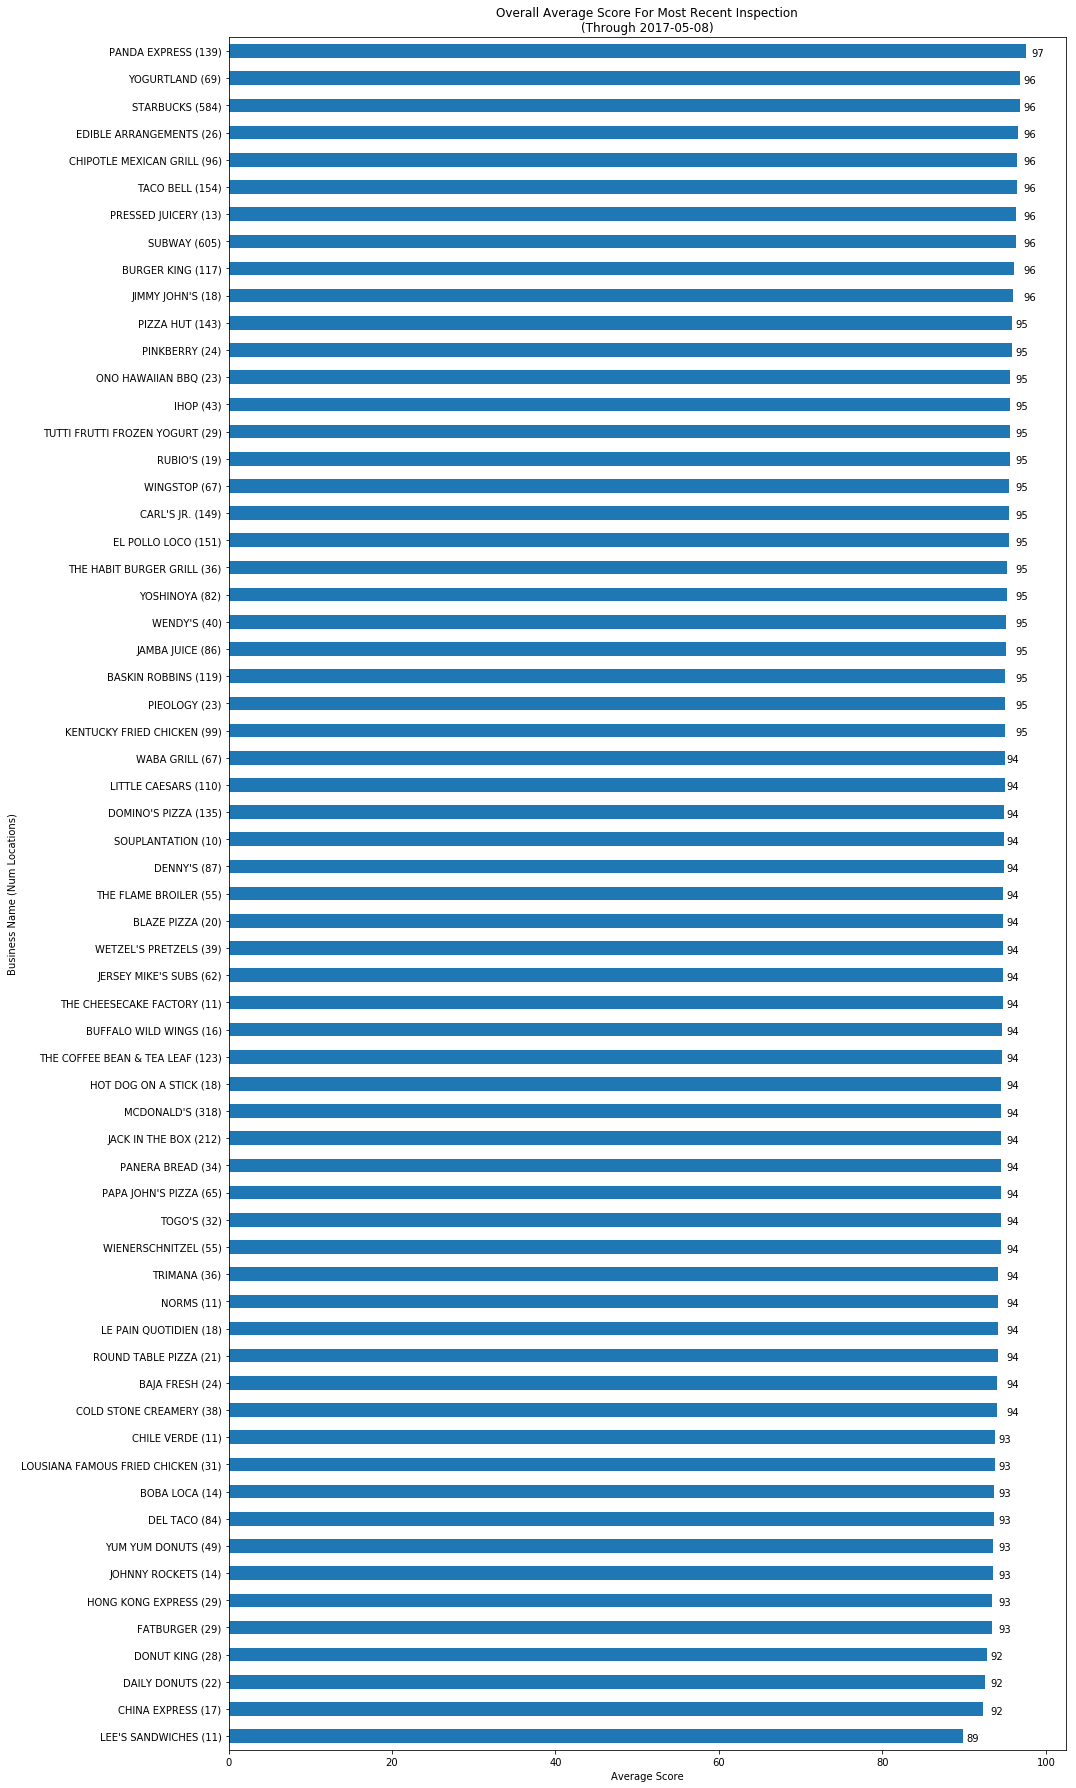

In [18]:
tmpdf = pd.merge(chdf, cdf, on='business_id')
tmpdf['group_avg_score'] = tmpdf.groupby('name')['score'].transform("mean")
tmpdf['group_min_score'] = tmpdf.groupby('name')['score'].transform("min")
tmpdf['group_max_score'] = tmpdf.groupby('name')['score'].transform("max")
tmpdf['group_median_score'] = tmpdf.groupby('name')['score'].transform("median")
cgldf = tmpdf.groupby(['name', 'group_avg_score',  'group_min_score', 'group_max_score', 'group_median_score']).size().to_frame('group_size').reset_index()
cgldf['name'] = cgldf['name'] + ' (' + cgldf['group_size'].astype(str) + ')'
cgldf = cgldf.set_index('name').sort_values('group_avg_score')
sns.reset_orig()
ax = cgldf['group_avg_score'].plot(kind='barh', figsize=(figsize[0], len(cgldf) * .5), title='Overall Average Score For Most Recent Inspection\n(Through {:%Y-%m-%d})'.format(latest_inspection_date))
ax.set_xlabel('Average Score')
ax.set_ylabel('Business Name (Num Locations)')
rects = ax.patches
labels = ['{:d}'.format(i.astype(int)) for i in cgldf['group_avg_score'].values]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + int(label) + 2, rect.get_y(), label, ha='center', va='bottom')
pass

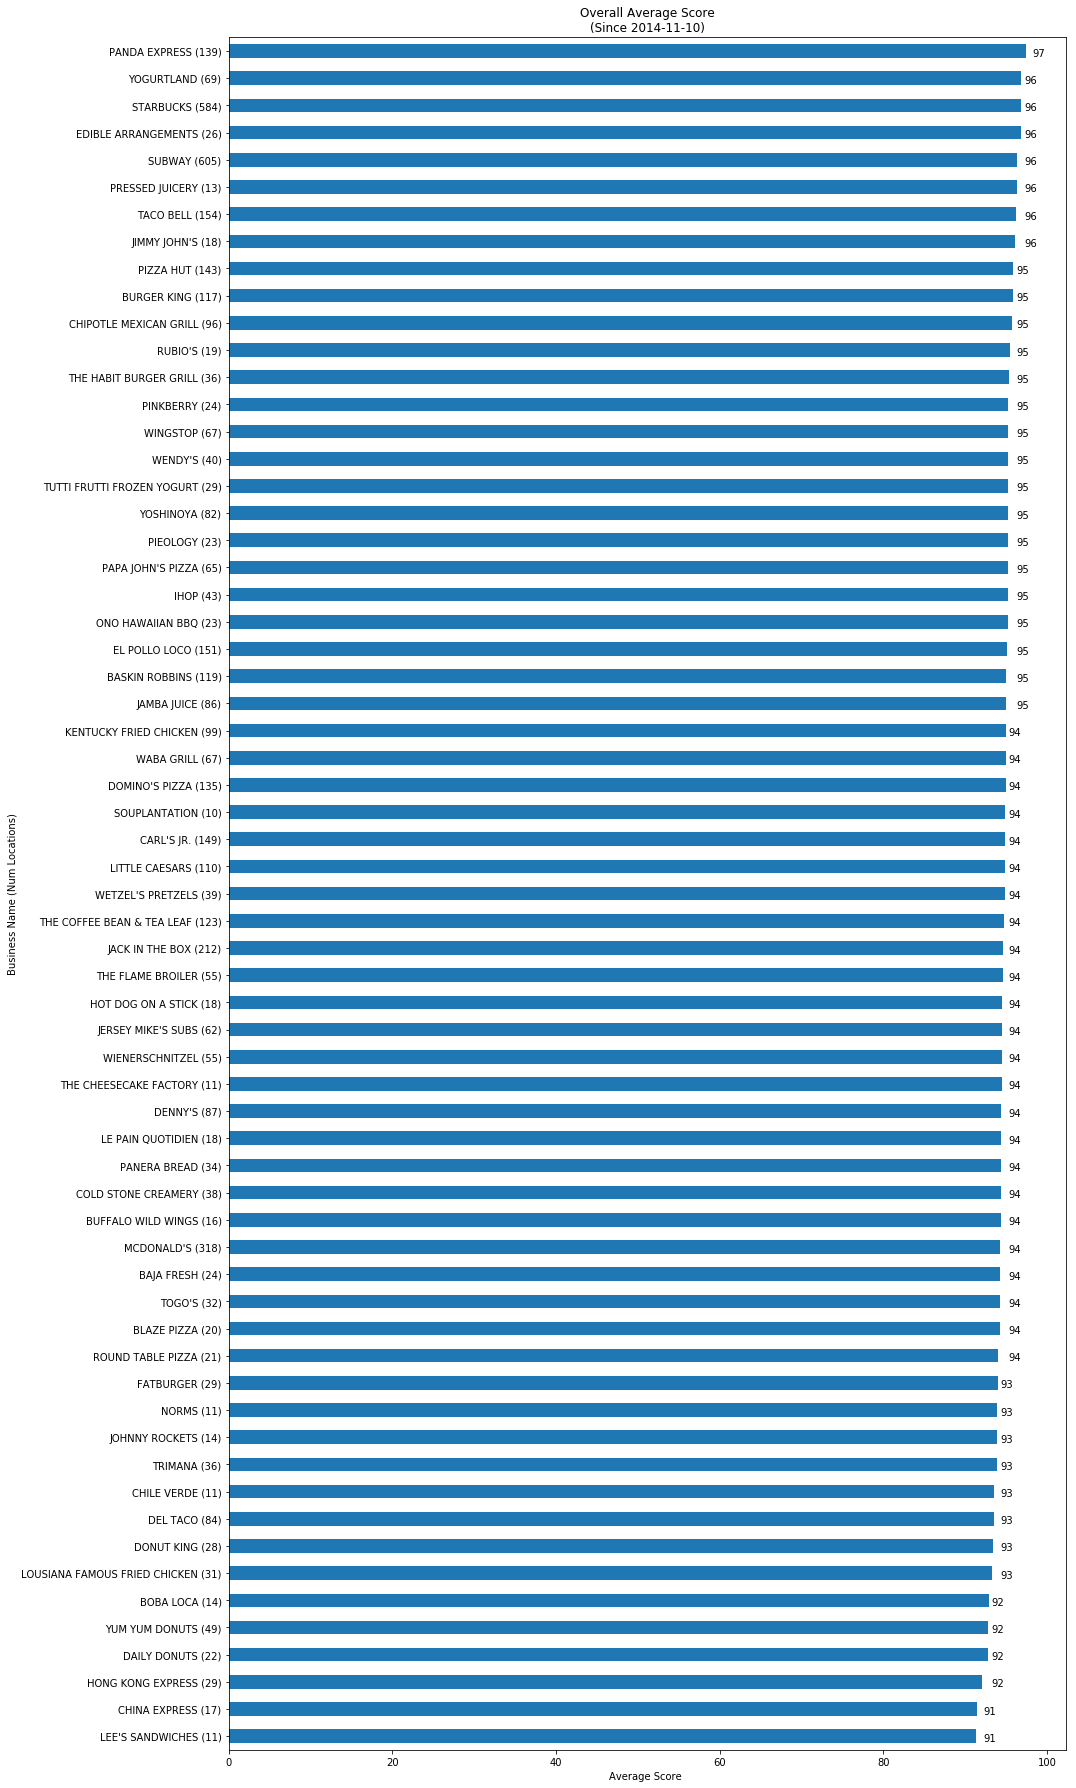

In [19]:
tmpdf = pd.merge(chdf, idf.groupby(['business_id', 'avg_score', 'min_score', 'max_score', 'median_score']).size().to_frame('num_inspections').reset_index(), on='business_id')
tmpdf['group_avg_score'] = tmpdf.groupby('name')['avg_score'].transform("mean")
tmpdf['group_min_score'] = tmpdf.groupby('name')['min_score'].transform("min")
tmpdf['group_max_score'] = tmpdf.groupby('name')['max_score'].transform("max")
tmpdf['group_median_score'] = tmpdf.groupby('name')['median_score'].transform("median")
cgadf = tmpdf.groupby(['name', 'group_avg_score',  'group_min_score', 'group_max_score', 'group_median_score']).size().to_frame('group_size').reset_index()
cgadf['name'] = cgadf['name'] + ' (' + cgadf['group_size'].astype(str) + ')'
cgadf = cgadf.set_index('name').sort_values('group_avg_score')
sns.reset_orig()
ax = cgadf['group_avg_score'].plot(kind='barh', figsize=(figsize[0], len(cgadf) * .5), title='Overall Average Score\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xlabel('Average Score ')
ax.set_ylabel('Business Name (Num Locations)')
rects = ax.patches
labels = ['{:d}'.format(i.astype(int)) for i in cgadf['group_avg_score'].values]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + int(label) + 2, rect.get_y(), label, ha='center', va='bottom')
pass

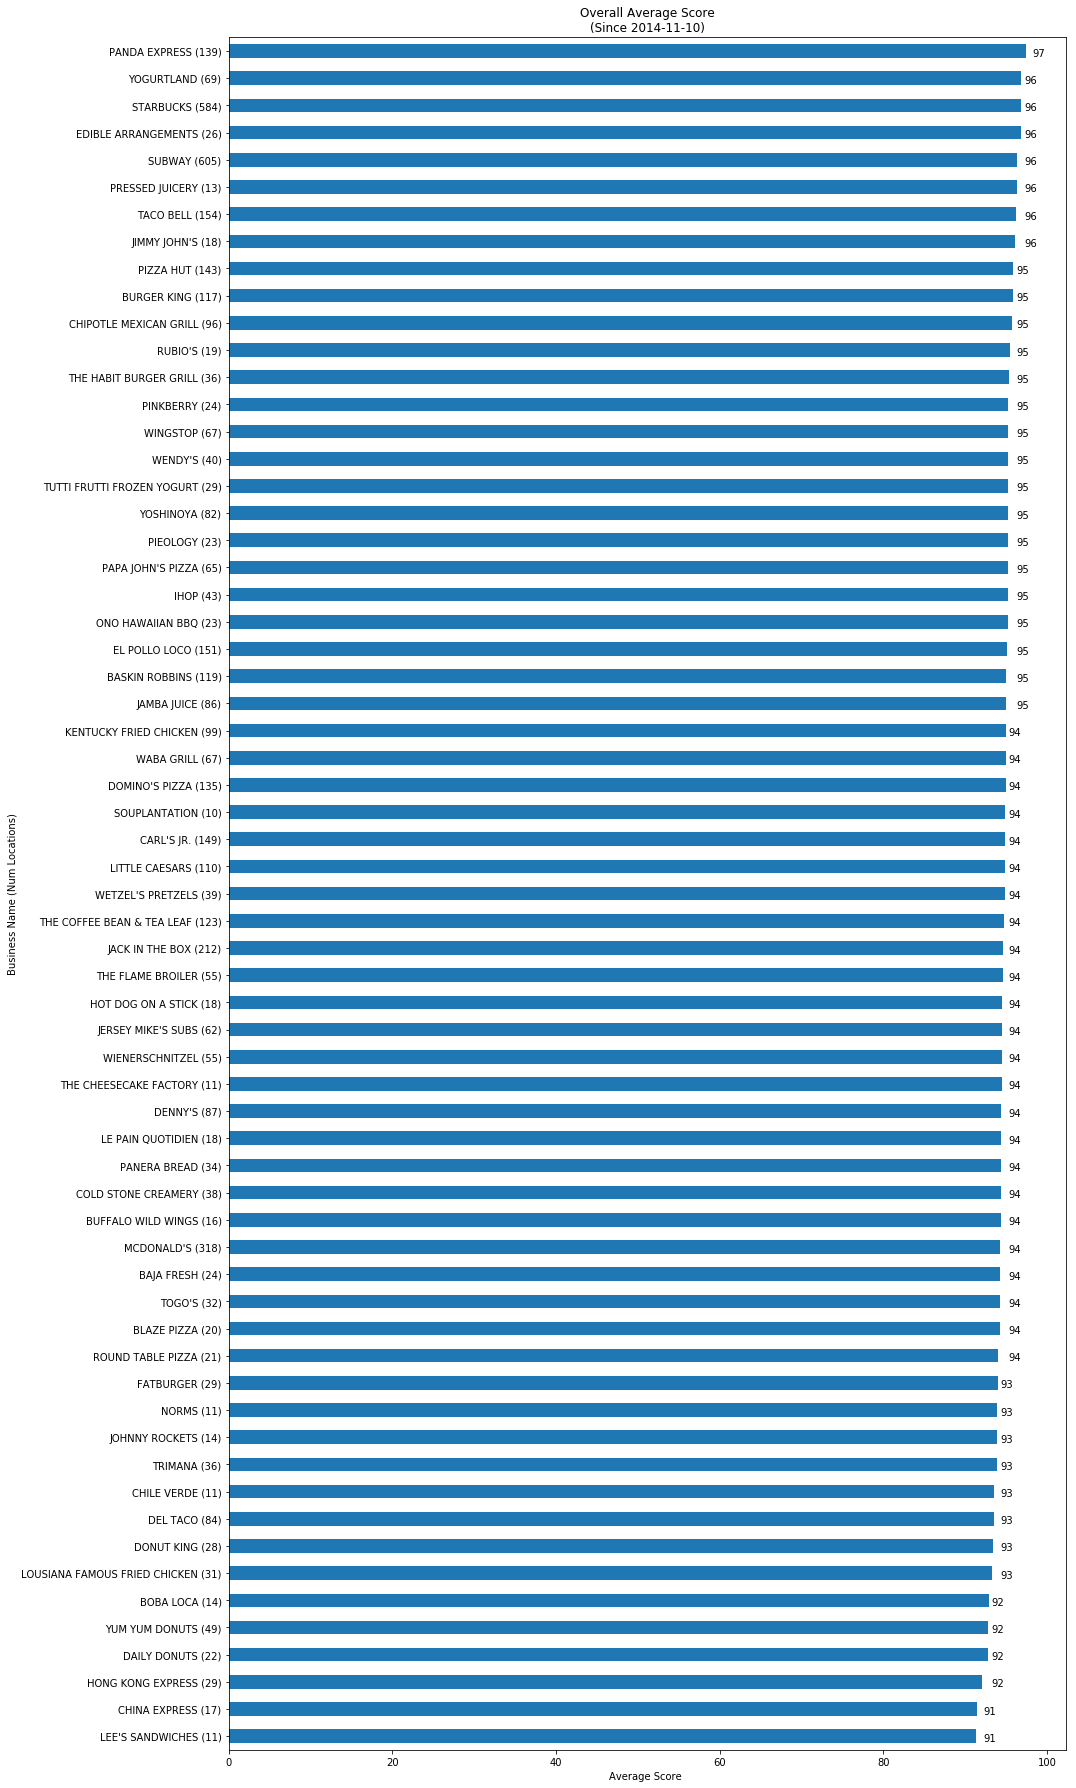

In [20]:
tmpdf = pd.merge(chdf, idf.groupby(['business_id', 'avg_score', 'min_score', 'max_score', 'median_score']).size().to_frame('num_inspections').reset_index(), on='business_id')
tmpdf['group_avg_score'] = tmpdf.groupby('name')['avg_score'].transform("mean")
tmpdf['group_min_score'] = tmpdf.groupby('name')['min_score'].transform("min")
tmpdf['group_max_score'] = tmpdf.groupby('name')['max_score'].transform("max")
tmpdf['group_median_score'] = tmpdf.groupby('name')['median_score'].transform("median")
cgadf = tmpdf.groupby(['name', 'group_avg_score',  'group_min_score', 'group_max_score', 'group_median_score']).size().to_frame('group_size').reset_index()
cgadf['name'] = cgadf['name'] + ' (' + cgadf['group_size'].astype(str) + ')'
cgadf = cgadf.set_index('name').sort_values('group_avg_score')
sns.reset_orig()
ax = cgadf['group_avg_score'].plot(kind='barh', figsize=(figsize[0], len(cgadf) * .5), title='Overall Average Score\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xlabel('Average Score ')
ax.set_ylabel('Business Name (Num Locations)')
rects = ax.patches
labels = ['{:d}'.format(i.astype(int)) for i in cgadf['group_avg_score'].values]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + int(label) + 2, rect.get_y(), label, ha='center', va='bottom')
pass

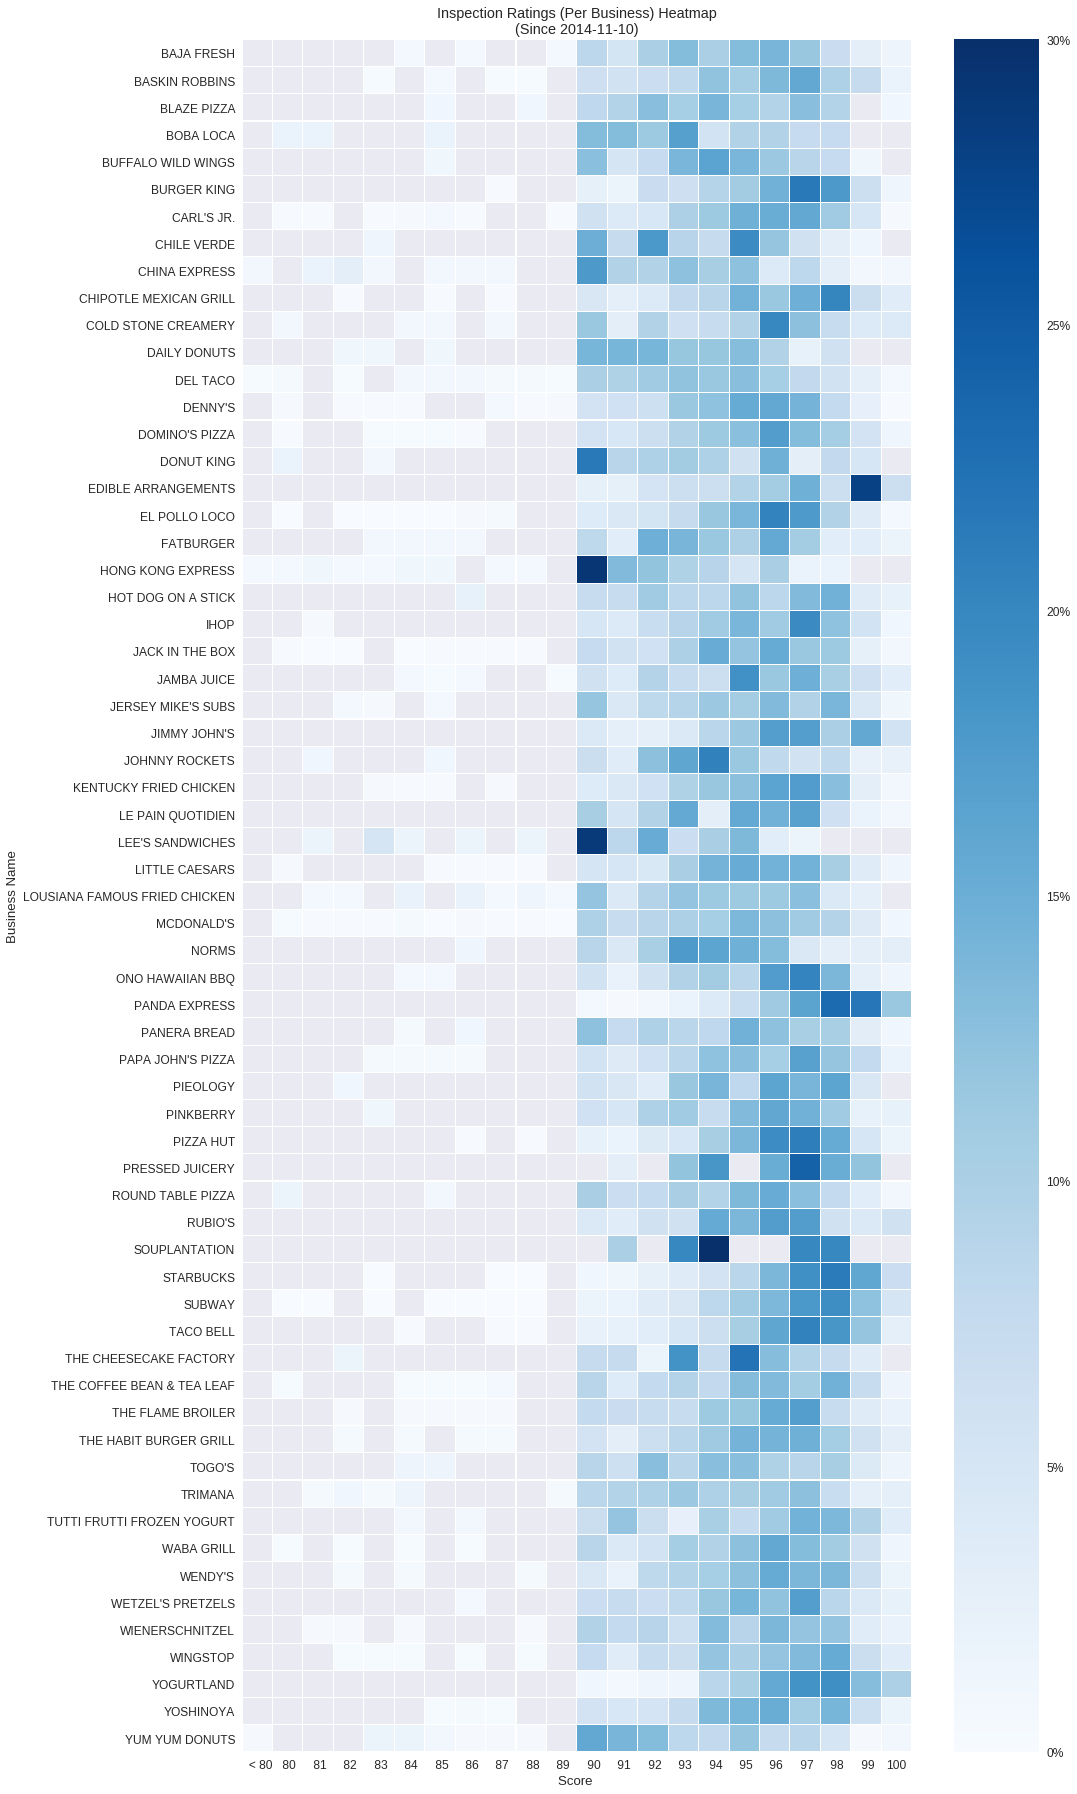

In [21]:
rnadf = pd.merge(chdf, idf[idf['score'] >= 80], on='business_id').groupby(['name', 'score']).size().to_frame('score_count').reset_index()
rnadf['score'] = rnadf['score'].astype(str).str.pad(3)
tmpdf = pd.merge(chdf, idf[idf['score'] < 80], on='business_id').groupby('name').size().to_frame('score_count').reset_index()
tmpdf['score'] = '  < 80'
rnadf = rnadf.append(tmpdf)
rnadf['percent'] = rnadf['score_count'] / rnadf['score_count'].groupby(rnadf['name']).transform('sum') * 100
rnadf = pd.pivot_table(rnadf, values='percent', columns='score', index='name').fillna(0)
sns.set(font_scale=1.2)
sns.set_style({"savefig.dpi": 100})
ax = sns.heatmap(rnadf, cmap=plt.cm.Blues, linewidths=.1,  cbar_kws={'format': '%.0f%%'}, mask=(rnadf==0))
ax.set_title('Inspection Ratings (Per Business) Heatmap\n(Since {:%Y-%m-%d})'.format(earliest_inspection_date))
ax.set_xlabel('Score ')
ax.set_ylabel('Business Name')
plt.xticks(rotation=0)
fig = ax.get_figure()
fig.set_size_inches(figsize[0], len(rnadf) * .5)
pass

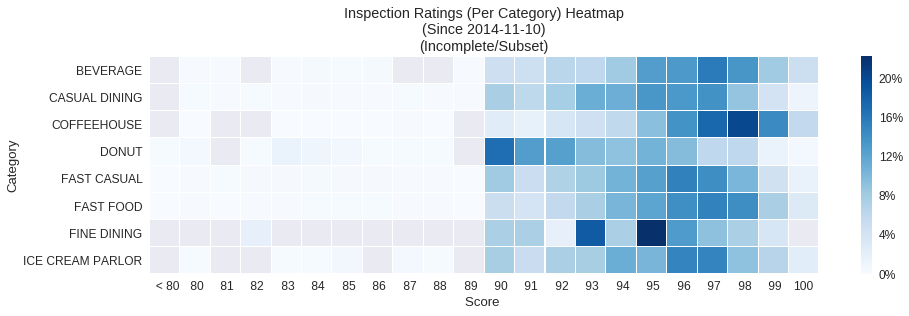

In [22]:
rchdf = pd.merge(chdf, idf[idf['score'] >= 80], on='business_id').groupby(['category', 'score']).size().to_frame('score_count').reset_index()
rchdf['score'] = rchdf['score'].astype(str).str.pad(3)
tmpdf = pd.merge(chdf, idf[idf['score'] < 80], on='business_id').groupby('category').size().to_frame('score_count').reset_index()
tmpdf['score'] = '  < 80'
rchdf = rchdf.append(tmpdf)
rchdf['percent'] = rchdf['score_count'] / rchdf['score_count'].groupby(rchdf['category']).transform('sum') * 100
rchdf = pd.pivot_table(rchdf, values='percent', columns='score', index='category').fillna(0)
sns.set(font_scale=1.2)
sns.set_style({"savefig.dpi": 100})
ax = sns.heatmap(rchdf, cmap=plt.cm.Blues, linewidths=.1,  cbar_kws={'format': '%.0f%%'}, mask=(rchdf==0))
ax.set_title('Inspection Ratings (Per Category) Heatmap\n(Since {:%Y-%m-%d})\n(Incomplete/Subset)'.format(earliest_inspection_date))
ax.set_xlabel('Score ')
ax.set_ylabel('Category')
plt.xticks(rotation=0)
fig = ax.get_figure()
fig.set_size_inches(figsize[0], len(rchdf) * .5)
pass

In [23]:
#bdf[bdf['name'].str.contains('BOBA') & bdf['name'].str.contains('LOCA']

In [24]:
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("PIEOLOGY"), 'PIEOLOGY', 'CASUAL DINING'))
chdf = chdf.append(init_busgrp(bdf['name'].str.contains("CHEESE") & bdf['name'].str.contains("CAKE") & bdf['name'].str.contains("FACTORY"), 'THE CHEESECAKE FACTORY', 'FINE DINING'))

In [25]:
bdf[bdf['name'] == "CHEESE CAVE"]

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
5157,PR0036711,CHEESE CAVE,325 N YALE AVE,CLAREMONT,CA,91711,34.096885,-117.718031,NaN


In [26]:
bdf[bdf['name'].str.contains("CHEESE") & bdf['name'].str.contains("CAKE") & bdf['name'].str.contains("FACTORY")].groupby('name').size()

name
THE CHEESE CAKE FACTORY    2
THE CHEESECAKE FACTORY     9
dtype: int64